In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [49]:
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)

In [50]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

In [51]:
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary


In [52]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [53]:
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Seed set to 0


In [54]:
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)


In [2]:
import math 

In [12]:
beta = np.arange(-6, 6, 0.05)


In [13]:
def r_func(beta):
    return math.sin(beta) + beta/10


r_beta = np.array([r_func(nr) for nr in beta])

<Axes: >

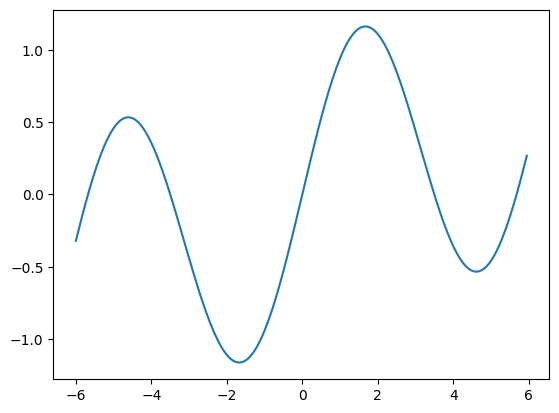

In [14]:
sns.lineplot(x=beta, y=r_beta)

In [29]:
def r_func_prime(nr):
    return math.cos(nr) + (1/10)

learning_rate = 0.1

b0 = 1.4

min_r = r_func(b0)
print(f'b0: {b0}, r(b0): {min_r}')

r_b0_prime = r_func_prime(b0)

if r_b0_prime > 0:
    b1 = b0 - learning_rate
else:
    b1 = b0 + learning_rate

r_b1 = r_func(b1)

if r_b1 < min_r:
    print(f'b1: {b1}, r(b1): {r_b1}')

new_min = r_b1
b_prior = b1
i = 2

while new_min < min_r:
    min_r = new_min
    derivative = r_func_prime(b_prior)
    if derivative > 0:
        b_posterior = b_prior - learning_rate
    else:
        b_posterior = b_prior + learning_rate
    new_min = r_func(b_posterior)
    if new_min < min_r:
        print(f'b{i}: {b_posterior}, r(b{i}): {new_min}')
    i += 1
    b_prior = b_posterior

r_func(4.7)

b0: 1.4, r(b0): 1.12544972998846
b1: 1.2999999999999998, r(b1): 1.093558185417193
b2: 1.1999999999999997, r(b2): 1.0520390859672262
b3: 1.0999999999999996, r(b3): 1.001207360061435
b4: 0.9999999999999997, r(b4): 0.9414709848078964
b5: 0.8999999999999997, r(b5): 0.8733269096274832
b6: 0.7999999999999997, r(b6): 0.7973560908995225
b7: 0.6999999999999997, r(b7): 0.7142176872376909
b8: 0.5999999999999998, r(b8): 0.6246424733950351
b9: 0.4999999999999998, r(b9): 0.5294255386042027
b10: 0.3999999999999998, r(b10): 0.4294183423086503
b11: 0.2999999999999998, r(b11): 0.32552020666133935
b12: 0.19999999999999982, r(b12): 0.21866933079506104
b13: 0.09999999999999981, r(b13): 0.10983341664682794
b14: -1.942890293094024e-16, r(b14): -2.1371793224034264e-16
b15: -0.1000000000000002, r(b15): -0.10983341664682837
b16: -0.2000000000000002, r(b16): -0.21866933079506143
b17: -0.3000000000000002, r(b17): -0.3255202066613398
b18: -0.40000000000000024, r(b18): -0.4294183423086508
b19: -0.5000000000000002, 

-0.5299232575641009

In [48]:
from ISLP import load_data
default = load_data('Default')
default.head()

default.dropna(how='any', inplace=True)
default['student'] = default['student'].astype(str)
default['default'] = default['default'].astype(str)
default.loc[default['student'] == 'Yes', 'student'] = 1
default.loc[default['student'] == 'No', 'student'] = 0
default.loc[default['default'] == 'Yes', 'default'] = 1
default.loc[default['default'] == 'No', 'default'] = 0
default.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


In [56]:
model = MS(default.columns.drop('default'), intercept=False)
X = model.fit_transform(default).to_numpy()
Y = default['default'].to_numpy()
X.shape

(10000, 3)

In [57]:
(X_train, 
 X_test,
 Y_train,
 Y_test) = train_test_split(X,
                            Y,
                            test_size=1/4,
                            random_state=1)

In [59]:
class DefaultModel(nn.Module):

    def __init__(self, input_size):
        super(DefaultModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10, 1))

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [60]:
def_model = DefaultModel(X.shape[1])
X.shape[1]

3

In [61]:
summary(def_model, 
        input_size=X_train.shape,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DefaultModel                             [7500, 3]                 [7500]                    --
├─Flatten: 1-1                           [7500, 3]                 [7500, 3]                 --
├─Sequential: 1-2                        [7500, 3]                 [7500, 1]                 --
│    └─Linear: 2-1                       [7500, 3]                 [7500, 10]                40
│    └─ReLU: 2-2                         [7500, 10]                [7500, 10]                --
│    └─Dropout: 2-3                      [7500, 10]                [7500, 10]                --
│    └─Linear: 2-4                       [7500, 10]                [7500, 1]                 11
Total params: 51
Trainable params: 51
Non-trainable params: 0
Total mult-adds (M): 0.38
Input size (MB): 0.09
Forward/backward pass size (MB): 0.66
Params size (MB): 0.00
Estimated Total Size (MB): 0.75

In [62]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
def_train = TensorDataset(X_train_t, Y_train_t)

In [63]:
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
def_test = TensorDataset(X_test_t, Y_test_t)

In [64]:
max_num_workers = rec_num_workers()

In [65]:
def_dm = SimpleDataModule(def_train,
                          def_test,
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=def_test)

In [66]:
def_module = SimpleModule.regression(def_model,
                           metrics={'mae':MeanAbsoluteError()})

In [67]:
def_logger = CSVLogger('logs', name='default')

In [68]:
def_trainer = Trainer(deterministic=True,
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=def_logger,
                      callbacks=[ErrorTracker()])
def_trainer.fit(def_module, datamodule=def_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: logs/default

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | DefaultModel | 51     | train
1 | loss  | MSELoss      | 0      | train
-----------------------------------------------
51        Trainable params
0         Non-trainable params
51        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [69]:
def_trainer.test(def_module, datamodule=def_dm)

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.030605565756559372
        test_mae            0.0631060004234314
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.030605565756559372, 'test_mae': 0.0631060004234314}]

In [70]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

In [72]:
def_results = pd.read_csv(def_logger.experiment.metrics_file_path)

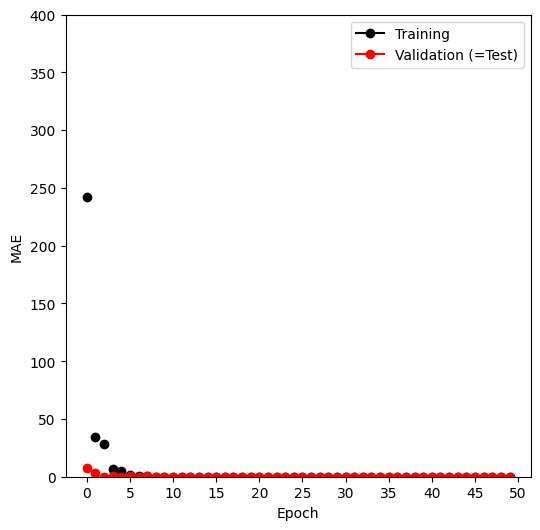

In [73]:
fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(def_results,
                  ax,
                  col='mae',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int))

In [74]:
def_model.eval() 
preds = def_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(0.0631, grad_fn=<MeanBackward0>)

# Comparing with lofistic regression

In [86]:
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1),
                                       np.log(1e-4), 50))

In [94]:
logit = LogisticRegression(penalty='l1', 
                           C=1/lam_max,
                           solver='liblinear',
                           warm_start=True,
                           fit_intercept=True)

Y_train = Y_train.astype(np.float32)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


In [95]:
coefs = []
intercepts = []

for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train, Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)

In [96]:
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)

In [100]:
preds = logit.predict(X_test)
np.abs(Y_test - preds).mean()

0.0256

# So logistic regression is BETTER

In [101]:
del(default,
    def_model, def_dm,
    def_logger,
    def_test, def_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    def_trainer, def_module)

# Exercise 8 - pretrained CNN prediction

Preprocessing images to fit specs of resnet50

In [104]:
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)

from glob import glob
import json

In [107]:
resize = Resize((232,232), antialias=True)
crop = CenterCrop(224)
normalize = Normalize([0.485,0.456,0.406],
                      [0.229,0.224,0.225])
imgfiles = sorted([f for f in glob('book_images/*')])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255)
                    for f in imgfiles])
imgs = normalize(imgs)
imgs.size()

torch.Size([5, 3, 224, 224])

In [108]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
summary(resnet_model,
        input_data=imgs,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [5, 3, 224, 224]          [5, 1000]                 --
├─Conv2d: 1-1                            [5, 3, 224, 224]          [5, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [5, 64, 112, 112]         [5, 64, 112, 112]         128
├─ReLU: 1-3                              [5, 64, 112, 112]         [5, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [5, 64, 112, 112]         [5, 64, 56, 56]           --
├─Sequential: 1-5                        [5, 64, 56, 56]           [5, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [5, 64, 56, 56]           [5, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [5, 64, 56, 56]           [5, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [5, 64, 56, 56]           [5, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

In [109]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [111]:
img_preds = resnet_model(imgs)
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]

labs = json.load(open('imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in 
                           labs.items()],
                           columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()


In [112]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:3]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))


Image: book_images/bobi.jpg
         label      prob
0        tabby  0.379339
1    tiger_cat  0.037983
2  Persian_cat  0.031818
Image: book_images/cat_statue.jpg
             label      prob
0       piggy_bank  0.261044
1  Indian_elephant  0.015066
2     hippopotamus  0.012252
Image: book_images/dog.jpg
                      label      prob
0                bloodhound  0.070122
1  Chesapeake_Bay_retriever  0.057431
2                   redbone  0.033003
Image: book_images/drawn_chimp.jpg
         label      prob
0   comic_book  0.070470
1  book_jacket  0.045984
2         mask  0.028386
Image: book_images/rabbit.jpg
         label      prob
0       Angora  0.425405
1  wood_rabbit  0.043682
2         hare  0.035899
